# EECS 731 Project 7: Visualization
## by Matthew Taylor

### Import required modules

For this project, I have decided to use matplotlib to illustrate various behaviors present in the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

### Import dataset

The dataset I chose to use for this project was the product demand dataset from the time series forecasting project. It had an abundace of numerical data with multiple features. These characteristics made it highly suitable for various visualizations techniques.

In [2]:
df = pd.read_csv('data/product_demand.csv').dropna()
df['Date'] = pd.to_datetime(df['Date'])

demands = []
for index, row in df.iterrows():
    demands.append(int(row['Order_Demand'].strip('()')))
    
df['Order_Demand'] = demands
del demands

df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


### Total Demand by Warehouse Over Time

One way to extract nonobvious information from this dataset is to group by one of the columns. First, I'll group the values in this dataset by warehouse in an attempt to find interesting trends.

In [3]:
# get relevant columns
warehouse_df = df[['Warehouse', 'Date', 'Order_Demand']]
warehouse_df.head()

,Warehouse,Date,Order_Demand
0,Whse_J,2012-07-27,100
1,Whse_J,2012-01-19,500
2,Whse_J,2012-02-03,500
3,Whse_J,2012-02-09,500
4,Whse_J,2012-03-02,500


In order to avoid an overly complicated plot, I have decided to group product demand by month. In order to do this, we must first find all possible warehouse values and group rows by those first.

In [4]:
set(warehouse_df.Warehouse.values)

{'Whse_A', 'Whse_C', 'Whse_J', 'Whse_S'}

Now that we know the names of all possible warehouses, we can group demands by warehouse, then by month. We must then strip some values from the heads and tails of each dataframe to ensure each dataframe has the same size. This is simply because some warehouses contain records before others. The timeframe that each of the warehouses have in common is from January 2012 to December 2016, so this will be the timeframe we will compare the total warehouse demands over.

In [5]:
wa_df = warehouse_df.loc[warehouse_df.Warehouse == 'Whse_A'].set_index('Date').drop(columns='Warehouse').resample('M').sum()
wc_df = warehouse_df.loc[warehouse_df.Warehouse == 'Whse_C'].set_index('Date').drop(columns='Warehouse').resample('M').sum()
wj_df = warehouse_df.loc[warehouse_df.Warehouse == 'Whse_J'].set_index('Date').drop(columns='Warehouse').resample('M').sum()
ws_df = warehouse_df.loc[warehouse_df.Warehouse == 'Whse_S'].set_index('Date').drop(columns='Warehouse').resample('M').sum()

wa_df.drop(wa_df.head(12).index, inplace=True)
wc_df.drop(wc_df.head(4).index, inplace=True)
wc_df.drop(wc_df.tail(1).index, inplace=True)
wj_df.drop(wj_df.head(2).index, inplace=True)
wj_df.drop(wj_df.tail(1).index, inplace=True)
ws_df.drop(ws_df.head(7).index, inplace=True)
ws_df.drop(ws_df.tail(1).index, inplace=True)

All that's left is to visualize the dataframes and find trends. By plotting these dataframes, we can clearly see that Warehouse J has a much higher demand than every other warehouse, while Warehouse A has a relatively low demand comparatively. Furthermore, one may notice that the overall demand of products from Warehouse C has historically been lower than the overall demand of products from Warehouse S. However, beginning in early 2016, this trend has been broken.

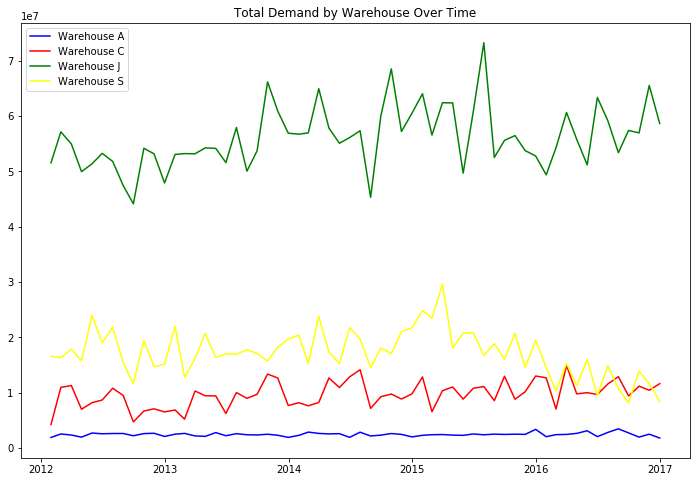

In [6]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.title('Total Demand by Warehouse Over Time')
plt.plot(wa_df, color='blue', label='Warehouse A')
plt.plot(wc_df, color='red', label='Warehouse C')
plt.plot(wj_df, color='green', label='Warehouse J')
plt.plot(ws_df, color='yellow', label='Warehouse S')
plt.legend(loc='best')
plt.show()

### Demand of a specific product by warehouse

This simple visualization may tell the owner various things about a product. To construct this pie chart, I simply selected a product that had demand in all four warehouses and grouped demands by warehouse. A chart like this, in conjunction with the locations of the warehouses may help identify geographic demand trends that can be used to allocate advertising funds more appropriately or help schedule deliveries.

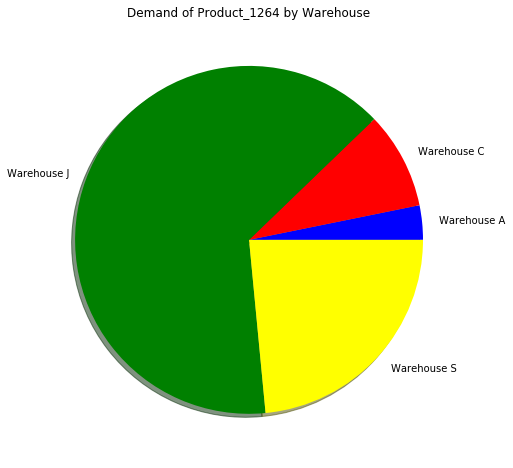

In [7]:
pie_df = df.loc[df.Product_Code == 'Product_1264'].drop(columns=['Product_Code', 'Date', 'Product_Category'])
pie_df = pie_df.groupby(['Warehouse']).sum()
labels = ['Warehouse A', 'Warehouse C', 'Warehouse J', 'Warehouse S']
colors = ['blue', 'red', 'green', 'yellow']
plt.title('Demand of Product_1264 by Warehouse')
plt.pie(pie_df['Order_Demand'], labels=labels, colors=colors, shadow=True)
plt.show()

### Demand seasonality

To find seasonality trends in various products, grouped product demands by month. However this technique varies slightly from the monthly grouping performed in the first visualization. Here, years are disregarded. The demands in January 2012, January 2013, etc. are all accumulated in the same variable. Once all demands are accounted for, the values are normalized to help the viewers focus more on seasonality rather than overall demand.

In [8]:
products = ['Product_1465', 'Product_1878', 'Product_1383', 'Product_1896']
s = []

for product in products:
    temp_df = df.loc[df.Product_Code == product]
    temp_df = temp_df.set_index('Date').drop(columns=['Warehouse', 'Product_Code', 'Product_Category']).resample('M').sum()
    
    temp_s = [0 for i in range(12)]
    j = 0
    for k in list(temp_df.Order_Demand.values):
        temp_s[j] += k
        
        if j == 11:
            j = 0
        else:
            j += 1
    
    total = sum(temp_s)
    for k in range(len(temp_s)):
        temp_s[k] /= total
        
    s.append(temp_s)

These products illustrate seasonal trends quite well. The products represented by the red and green lines have drastic spikes in demand in April compared to the rest of the year. Meanwhile, the product represented by the yellow line is in much higher demand during the summer than any other time. The demand of the product represented by the blue line is relatively high specifically in November. This information can be used to increase production and promote products whose demands are reaching their seasonal peaks.

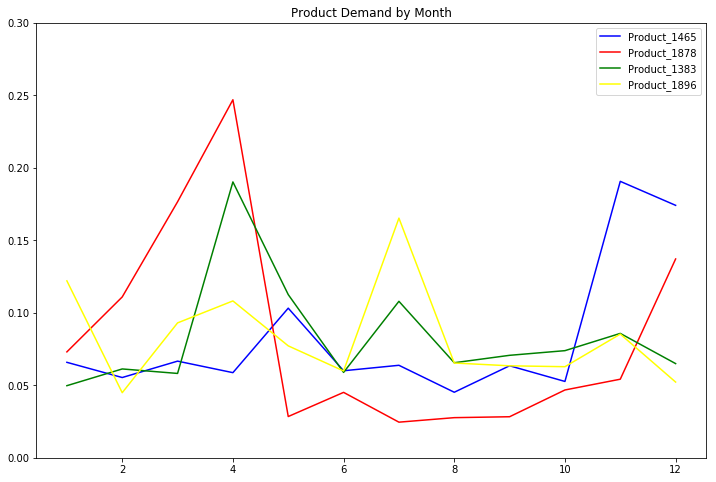

In [9]:
plt.rcParams['figure.figsize'] = [12, 8]
colors = ['blue', 'red', 'green', 'yellow']

plt.title('Product Demand by Month')

for i in range(len(s)):
    plt.plot(range(1, 13), s[i], color=colors[i], label=products[i])

plt.ylim((0, 0.3))
plt.legend(loc='best')
plt.show()